# Homework (15 points)

In this homework we train Sound Event Detection model.

Dataset: https://disk.yandex.ru/d/NRpDIp4jg2ODqg

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import requests
import tqdm.notebook as tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as torch_data
import torchaudio
import torchinfo
from collections import OrderedDict
import contextlib
import typing as tp
import urllib

# implementation of Dataset for given data|
import dataset

from IPython.display import clear_output

# %matplotlib inline

In [2]:
# import requests
# from urllib.parse import urlencode
# from io import BytesIO
# from tarfile import TarFile
# import tarfile

# base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
# public_key = 'https://disk.yandex.ru/d/NRpDIp4jg2ODqg'
# # dst_path = '/home/jupyter/mnt/datasets/sound_event_detection/dataset/' # if we make the Datasphere datasets work
dst_path = './dataset/'

In [3]:
DEVICE = 'cuda' # also you can use "cuda" for gpu and "mps" for apple silicon
DATADIR = dst_path + 'data'
LOADER_WORKERS = 8

SEED = 0

In [4]:
np.random.seed(SEED) 
torch.manual_seed(SEED) 
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [5]:
# FBANK 80 by default, but you can choose something else
FEATS = 80

transform_train = nn.Sequential(
    torchaudio.transforms.MelSpectrogram(n_mels=FEATS),
    torchaudio.transforms.AmplitudeToDB(), # melspec -> logmelspec
    
    # Basic augmentations: time and frequency masking
    torchaudio.transforms.FrequencyMasking(freq_mask_param=10),
    torchaudio.transforms.TimeMasking(time_mask_param=50, p=0.3),
)

transform_test = nn.Sequential(
    torchaudio.transforms.MelSpectrogram(n_mels=FEATS),
    torchaudio.transforms.AmplitudeToDB()  # melspec -> logmelspec
)

trainset = dataset.Dataset('train', DATADIR, transform_train)
testset = dataset.Dataset('eval', DATADIR, transform_test)

N_CLASSES = trainset.classes()

### Eval part (1 point)

Write balanced accuracy:
$$BAcc = \frac{1}{classes}\sum_{c = 1}^{classes} \frac{\sum_i^n I(y_i = p_i = c)}{\sum_i^n I(y_i = c)}$$

Where:
- $y_i$ -- target class for $i$ element
- $p_i$ -- predicted class for $i$ element

In [ ]:
# Get list of pairs (target_class, predicted_class)
from collections import defaultdict

def balanced_accuracy(items: list[tuple[int, int]]) -> float:
    
    # [number of elements in each class (denominator), number of true positive (numerator)]
    classes_dict = defaultdict(lambda: [0, 0])
    
    for target, pred in items: 
        curr_class = classes_dict[target] 
        curr_class[0] += 1
        curr_class[1] += (pred == target)
        
    result = sum(num / den for den, num in classes_dict.values()) / len(classes_dict)
    
    return result

In [7]:
assert np.isclose(balanced_accuracy([(0, 0), (0, 0), (1, 1)]), 1.0)
assert np.isclose(balanced_accuracy([(0, 1), (1, 0)]), 0.0)
assert np.isclose(balanced_accuracy([(0, 0), (0, 0), (1, 0)]), 0.5)
assert np.isclose(balanced_accuracy([(0, 0), (1, 1), (0, 0), (0, 0), (1, 0), (0, 1)]), 0.625)
assert np.isclose(balanced_accuracy([(1, 1), (0, 1), (2, 2)]), 0.66666666666666)

### Train part (14 points)

Train some model with test accuracy > 0.5

You can train any model you want. The only limitations are 
    1) it must be trained from scratch on the data provided in the task
    2) it must have less than 5M parameters

For example you can choose model from:
- DNN
- CNN 1d
- CNN 2d
- Transformer
- RNN
- mixes of given models

You can draw inspiration from the big models and build your own small model from scratch.
You can draw inspiration from the big models and build your own small model from scratch.

Hints:
- No need to train large models for this task. 5 million parameters is much more than you need.
- The score can be achieved by models with less than 100K params
- Take the feature dimension into account
- Monitor overfitting, try to add Augmentation, Dropout, BatchNorm, L1/L2-Regulatization or something else.
- Score of 0.35 is easily achievable by CNN 1d
- Use poolings or strides to reduce time-dimenstion. It is better to reduce the dimension gradually rather than at the end.
- Pay attention to the time dimension at the end of the network. How big is the receptive field of the network?
- Try different features (mel-spec, log-mel-spec, mfcc)
- You may need more than 10 epochs. One would would consider 20-30 epochs as a reasonable estimate
- You may need to use smaller batches)

P.S. Points can be subtracted for unclear training charts. Keep all the experiments that you've run in the notebook.

PP.S. It is sufficient for your model to beat the threshold once. We imagine a) there is a hidden best checkpoint save option and b) that the distribution of the test used to monitor the training is identical to the distribution of all possible tests)

PPP.S. A partial score will be awarded for a test accuracy < 0.5. Score of 0.35 is easily achievable by CNN 1d
PPP.S. A partial score will be awarded for a test accuracy < 0.5. Score of 0.35 is easily achievable by CNN 1d

PPPP.S. Add log to Melspectrogram in torchaudio.transform

#### Train/val loops:

**Train/val loops were slightly modified**: lr scheduler is added; `no_grad` for validation; model, optimizer and scheduler checkpointing; changes in plotting

In [ ]:
def get_num_params(model):
    result = 0
    for param in model.parameters():
        result += param.numel()
    return result


def stage(
    model: nn.Module,
    data: dataset.Dataset,
    optimizer: optim.Optimizer,
    scheduler: tp.Optional[torch.optim.lr_scheduler._LRScheduler] = None,
    batch_size: int = 256,
    train: bool = True
):
    loader = torch_data.DataLoader(
        data,
        batch_size=batch_size,
        shuffle=True if train else False,
        num_workers=LOADER_WORKERS,
        pin_memory=True,
        collate_fn=dataset.collate_fn
    )
    
    if train:
        model.train()
    else:
        model.eval()
        
    loss_sum, batches = 0.0, 0
    pred_pairs = []
    
    for X, Y in tqdm.tqdm(loader):
        with torch.no_grad() if not train else contextlib.nullcontext():
            pred = model(X.to(DEVICE))
            loss = F.cross_entropy(pred.squeeze(), Y.squeeze().to(DEVICE))
        
        if train:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        loss_sum += loss.item()
        batches += 1

        pred_pairs.extend(zip(
            Y.data.numpy().reshape(-1),
            torch.argmax(pred, dim=1).cpu().data.numpy().reshape(-1)
        ))
        
    if not train and scheduler:
        try:
            scheduler.step()
        except:
            scheduler.step(loss_sum / batches)
    
    return loss_sum / batches, balanced_accuracy(pred_pairs)


def train(
    model: nn.Module,
    optimizer: torch.optim.Optimizer,
    scheduler: torch.optim.lr_scheduler,
    batch_size: int = 256,
    epochs: int = 10,
) -> None:
    train_losses, test_losses, train_accs, test_accs = [], [], [], []
    for epoch in range(epochs):
        train_loss, train_acc = stage(model, trainset, optimizer, scheduler, batch_size=batch_size)
        test_loss, test_acc = stage(model, testset, optimizer, scheduler, batch_size=batch_size, train=False)
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        test_losses.append(test_loss)
        test_accs.append(test_acc)
        clear_output()
        
        fig, axis = plt.subplots(1, 2, figsize=(15, 7))
        axis[0].plot(np.arange(1, epoch + 2), train_losses, marker='.', label='train')
        axis[0].plot(np.arange(1, epoch + 2), test_losses, marker='.', label='test')
        axis[1].plot(np.arange(1, epoch + 2), train_accs, marker='.', label='train')
        axis[1].plot(np.arange(1, epoch + 2), test_accs, marker='.', label='test')
        axis[0].set(xlabel='epoch', ylabel='CE Loss', xlim=(1, None))
        axis[1].set(xlabel='epoch', ylabel='Balanced Accuracy', xlim=(1, None))
        #axis[0].minorticks_on(); axis[1].minorticks_on()
        axis[0].tick_params(axis='x', which='minor', bottom=False)
        axis[1].tick_params(axis='x', which='minor', bottom=False)
        axis[0].grid(True, 'minor', lw=0.2); axis[0].grid(True, 'major')
        axis[1].grid(True, 'minor', lw=0.2); axis[1].grid(True, 'major')
        axis[0].legend(); axis[1].legend()
        plt.show()
        
        print(f'Epoch {epoch + 1}.')
        print(f'Train loss {train_loss}. Train accuracy {train_acc}.')
        print(f'Test loss {test_loss}. Test accuracy {test_acc}')
        
        torch.save(model.state_dict(), f'model_{epoch}.pth')
        torch.save(optimizer.state_dict(), f'optimizer_{epoch}.pth')
        torch.save(scheduler.state_dict(), f'scheduler_{epoch}.pth')

#### Model architecture

There was a code template of **depthwise separable convolution**, so it will be used as a part of the model instead of standart 2D convolutions. In fact, DepthwiseSeparableConv2d weight tensor can be viewed as a low-rank decomposition of a standard 2D convolution, where the depthwise part acts on the spatial dimension independently for each channel, and the pointwise part reduces the dimensionality across channels with a 1x1 convolution. This significantly reduces number of parameters and FLOPs and speed-ups both train and inference.

**Resnet-like architecture with 2D depthwise convolutions** (`ConvResNet`) was selected as the model for the current task and was implemented from scratch. This architecture is commonly a good choice for 2D data processing, including spectrograms. Specifically, it is widely used in speech processing tasks. The head of the model consists of adaptive average pooling followed by a single fully connected (fc) layer.

A detailed visualization of the selected model is provided below. All implemented modules include type hints and documentation.

In [ ]:
class DepthwiseSeparableConv2d(nn.Module):
    def __init__(
        self, 
        in_channels: int, 
        out_channels: int,
        kernel_size: int | tuple[int, int], 
        stride: int | tuple[int, int] = 1, 
        padding: int | tuple[int, int] | str = 0,
        dilation: int | tuple[int, int] = 1,
        bias: bool = True,
        padding_mode: str = 'zeros'
    ) -> None:
        r"""Depthwise separable convolution layer, which consists of a depthwise convolution
        followed by a pointwise convolution. Parameters are aligned with pytorch Conv2d module

        Parameters
        ----------
        in_channels : int
            number of channels in the input tensor
        out_channels : int
            number of channels in the output tensor
        kernel_size : int | tuple[int, int]
            size of the convolution kernel
        stride : int | tuple[int, int], optional
            stride of the convolution, by default 1
        padding : int | tuple[int, int] | str, optional
            padding added to the last two dimensions of the input tensor, by default 0
        dilation : int | tuple[int, int], optional
            spacing between kernel elements, by default 1
        bias : bool, optional
            if True, adds a learnable bias to the output, by default True
        padding_mode : str, optional
            type of padding, by default 'zeros'
        """
        super().__init__()
        
        self.depthwise = nn.Conv2d(
            in_channels=in_channels,
            out_channels=in_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            dilation=dilation,
            groups=in_channels,
            bias=False,
            padding_mode=padding_mode
        )
        
        self.pointwise = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=1,
            padding=0,
            bias=bias
        )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.pointwise(self.depthwise(x))
    
    
class ResidualBlock(nn.Module):
    def __init__(
        self, 
        in_channels: int, 
        out_channels: int, 
        kernel_size: int | tuple[int, int], 
        activation: nn.Module, 
        dropout_p: float, 
        pool: nn.Module, 
        use_residual: bool, 
        num_convs: int,
        bias: bool = True,
        use_depthwise_separable: bool = False
    ) -> None:
        r"""Residual block that consists of a sequence of convolutional (or depthwise separable convolutional) layers, 
        batch normalization, activation and dropout, with an optional residual connection.

        Parameters
        ----------
        in_channels : int
            number of channels in the input tensor
        out_channels : int
            number of channels in the output tensor
        kernel_size : int | tuple[int, int]
            size of the convolution kernel
        activation : nn.Module
            activation function to use after each convolution
        dropout_p : float
            dropout probability
        pool : nn.Module
            pooling layer to use after the block
        use_residual : bool
            if True, adds a residual connection to the output
        num_convs : int
            number of convolutional layers in the block
        bias : bool, optional
            if True, adds a learnable bias to the output, by default True
        use_depthwise_separable : bool, optional
            if True, uses depthwise separable convolutions, by default False
        """
        super().__init__()
        self.num_convs = num_convs
        
        _kernel_size = kernel_size if isinstance(kernel_size, list) else [kernel_size]
        if not all(x % 2 == 1 for x in _kernel_size):
            raise ValueError("Only odd-size kernels are supported")
        
        conv_class = nn.Conv2d if not use_depthwise_separable else DepthwiseSeparableConv2d
        
        # main branch: sequence of conv2d -> batchnorm -> activation -> dropout
        self.blocks = nn.Sequential(
            *(nn.Sequential(OrderedDict([
                ('conv', conv_class(
                    in_channels=in_channels if idx == 0 else out_channels,
                    out_channels=out_channels, 
                    kernel_size=kernel_size,
                    padding='same',
                    bias=bias)
                ),
                ('bnorm', nn.BatchNorm2d(
                    num_features=out_channels)
                ),
                ('act', activation
                ),
                ('drop', nn.Dropout2d(
                    p=dropout_p)
                ),
            ])) for idx in range(self.num_convs))
        )
            
        self.pool = pool if pool is not None else nn.Identity()
        
        self.use_residual = use_residual
        
        # residual branch: 1x1 convolution if channel dimensions don't match
        if in_channels != out_channels and self.use_residual:
            self.rc = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1)
        else:
            self.rc = nn.Identity()

    def forward(self, x: torch.Tensor) -> torch.Tensor:            
        return self.pool(self.blocks(x) + self.rc(x))
    
    
class ConvResNet(nn.Module):
    def __init__(
        self,
        input_channels: int,
        num_conv_layers: int,
        kernel_sizes: int | list[int],
        hidden_sizes: int | list[int],
        activations: nn.Module | list[nn.Module],
        dropouts_p: float | list[float],
        poolings: nn.Module | list[nn.Module],
        output_dim: int,
        residual_block_sizes: int | list[int],
        global_pooling: nn.Module,
        use_depthwise_separable: bool = False
    ) -> None:
        r"""Resnet-like CNN

        Parameters
        ----------
        input_channels : int
            number of channels in the input tensor
        num_conv_layers : int
            number of ResidualBlocks in the network
        kernel_sizes : int | list[int]
            size of the convolution kernel for each layer
        hidden_sizes : int | list[int]
            number of hidden and output channels for each convolutional layer
        activations : nn.Module | list[nn.Module]
            activation function to use after each convolution
        dropouts_p : float | list[float]
            dropout probability
        poolings : nn.Module | list[nn.Module]
            pooling layer to use in the each ResidualBlock layer
        output_dim : int
            number of output classes
        residual_block_sizes : int | list[int]
            number of convolutional layers in each residual block
        global_pooling : nn.Module
            global pooling layer to use before the final fully connected layer
        use_depthwise_separable : bool, optional
            if True, uses depthwise separable convolutions, by default False
        """
        super().__init__()
        
        if not isinstance(kernel_sizes, list):
            kernel_sizes = [kernel_sizes] * num_conv_layers
        if len(kernel_sizes) != num_conv_layers:
            raise ValueError("len(kernel_sizes) must be equal to num_conv_layers")
        
        if isinstance(hidden_sizes, list):
            if len(hidden_sizes) != num_conv_layers:
                raise ValueError("len(hidden_sizes) must be equal to num_conv_layers")
            hidden_sizes = [input_channels] + hidden_sizes
        else:
            hidden_sizes = [input_channels] + [hidden_sizes] * num_conv_layers
            
        if not isinstance(activations, list):
            activations = [activations] * num_conv_layers
        if len(activations) != num_conv_layers:
            raise ValueError("len(activations) must be equal to num_conv_layers")
        
        if not isinstance(dropouts_p, list):
            dropouts_p = [dropouts_p] * num_conv_layers
        if len(dropouts_p) != num_conv_layers:
            raise ValueError("len(dropouts_p) must be equal to num_conv_layers")
        
        if not isinstance(poolings, list):
            poolings = [poolings] * num_conv_layers
        if len(poolings) != num_conv_layers:
            raise ValueError("len(poolings) must be equal to num_conv_layers")
        available_poolings = [None, nn.AvgPool2d, nn.MaxPool2d]
        if not all(p in available_poolings for p in poolings):
            raise ValueError(f"available poolings are: {available_poolings}")
        poolings = [poolings[idx](kernel_size=2) if poolings[idx] else nn.Identity() for idx in range(num_conv_layers)]
        
        if not isinstance(residual_block_sizes, list):
            residual_block_sizes = [residual_block_sizes] * num_conv_layers
        if len(residual_block_sizes) != num_conv_layers:
            raise ValueError("len(residual_block_sizes) must be equal to num_conv_layers")
        
        self.residual_blocks = nn.Sequential(
            *(ResidualBlock(
                in_channels=hidden_sizes[idx],
                out_channels=hidden_sizes[idx + 1],
                kernel_size=kernel_sizes[idx],
                activation=activations[idx],
                dropout_p=dropouts_p[idx],
                pool=poolings[idx],
                use_residual=True,
                num_convs=residual_block_sizes[idx],
                use_depthwise_separable=use_depthwise_separable
            )
            for idx in range(num_conv_layers))
        )
        
        available_global_poolings = [None, nn.AdaptiveAvgPool2d, nn.AdaptiveMaxPool2d]
        if global_pooling not in available_global_poolings:
            raise ValueError(f"available global poolings are: {available_global_poolings}")
        
        self.global_pooling = global_pooling(output_size=1) if global_pooling else nn.Identity()
        
        self.flatten = nn.Flatten(start_dim=1, end_dim=3)
        self.fc = nn.Linear(hidden_sizes[-1], output_dim)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # input: [batch_size, IN_FEATURES, TIME]
        # output: [batch_size, N_CLASSES]
        
        out_rb = self.residual_blocks(x[:, None, :, :])
        out_gp = self.flatten(self.global_pooling(out_rb))
        out = self.fc(out_gp)
        
        return out
        

In [11]:
model = ConvResNet(
    input_channels=1,
    num_conv_layers=6,
    kernel_sizes=3,
    hidden_sizes=[16, 32, 64, 64, 128, 128],
    activations=nn.Hardswish(inplace=True),
    dropouts_p=0.1,
    poolings=nn.AvgPool2d,
    output_dim=N_CLASSES,
    residual_block_sizes=2,
    global_pooling=nn.AdaptiveAvgPool2d,
    use_depthwise_separable=True
)

Model's hyperparameters were selected to fit into 100K total number of parameters. It easily achieves the declared balanced accuracy threshold 0.5. The number of feature maps steadily increase from input to output of the model. Each of 6 `ResidualBlock`s consist of 2 sequential set of (`DepthwiseSeparableConv2d -> BatchNorm2d -> Hardswish -> Dropout2d`) operations with residual connection, `ResidualBlock` ends with `AvgPool2d`. Hardswish is selected as activation function as it's widely used in speech processing applications. Model's head is `AdaptiveAvgPool2d` with one fc layer (128 -> 30)  

In [12]:
param_num = 0
for p in model.parameters():
    param_num += p.numel()
print(f"Total number of parameters: {param_num}")

Total number of parameters: 97591


#### Let's visualize the model

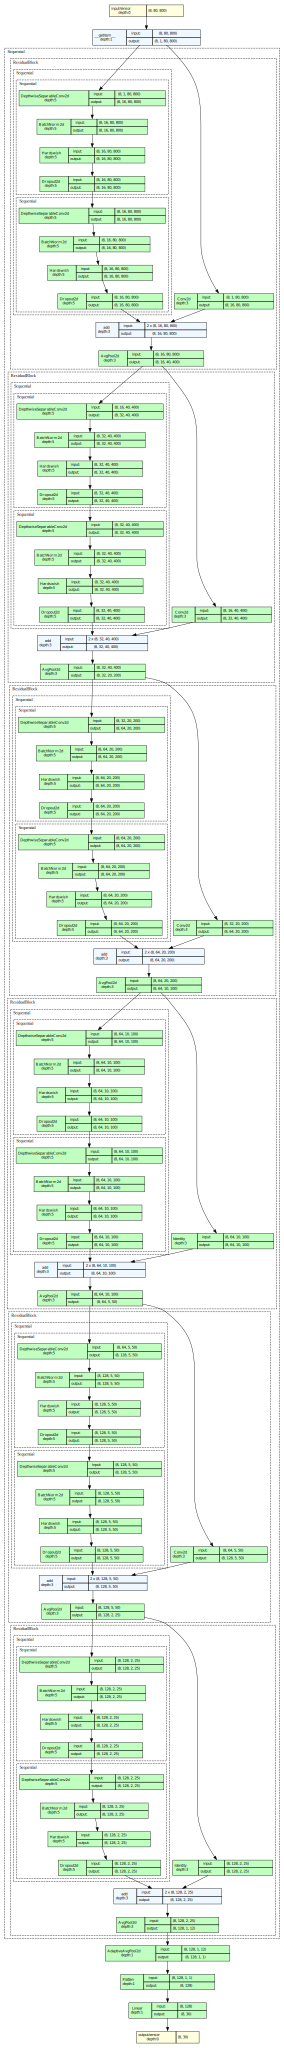

In [13]:
from torchview import draw_graph

model_graph = draw_graph(
    model, 
    input_size=(8, 80, 800), 
    expand_nested=True, 
    depth=5,
    graph_dir='TB'
)
model_graph.visual_graph

## Train the model

In [14]:
model = model.to(DEVICE)
print("Number of parameters is ", get_num_params(model))

optimizer = optim.AdamW(
    params=model.parameters(),
    lr=1e-2,
    weight_decay=1e-6  # l2-regularization
)

scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.9)  # lr exponential decay

Number of parameters is  97591


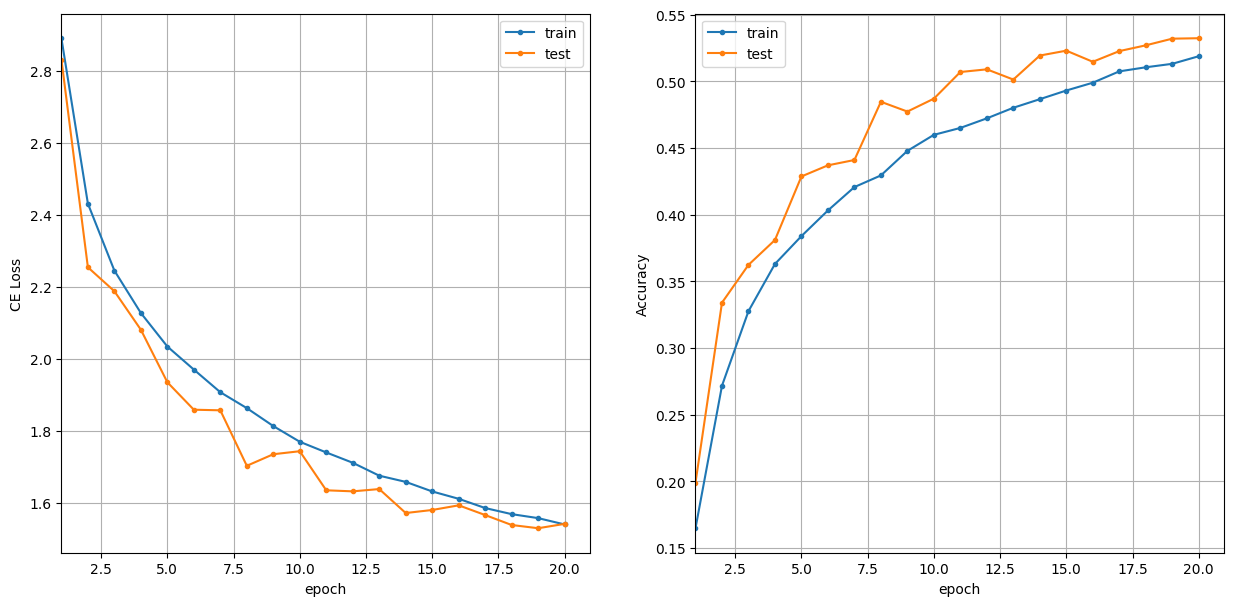

Epoch 20.
Train loss 1.5401192983476126. Train accuracy 0.5188292487294343.
Test loss 1.5417523840640455. Test accuracy 0.5323333333333333


In [15]:
train(
    model=model, 
    optimizer=optimizer,
    scheduler=scheduler,
    batch_size=64,
    epochs=20
)

## Closing remarks

As one can see, Resnet-like model with separable 2D convolutions easily reached balanced accuracy score more than 0.5 in 20 epochs, at the same time it's relatively compact, with fewer than 100K parameters (specifically 97591). The training plots indicate good performance, with train and test losses and metrics being monotonic and well-aligned. The model did not overfit due to data augmentation (time and frequency masking) and regularization methods (AdamW optimizer with L2 regularization, 2D Dropout, 2D Batch normalization). The small number of parameters in the model also helped prevent overfitting on the training dataset.